# Analysing PCA Performance

## Imports

In [1]:
from stable_baselines import DDPG
import os 
import pandas as pd
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.noise import OrnsteinUhlenbeckActionNoise
import sys
import time
from pyfolio import timeseries
from tabulate import tabulate
from ta import add_all_ta_features
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

sys.path.append("../")
from FunctionFiles.pipeline.preprocessors import *
from FunctionFiles.env.EnvMultipleStock_trade import StockEnvTrade
from FunctionFiles.env.EnvMultipleStock_train import StockEnvTrain
from FunctionFiles.pipeline.backtesting_pipeline import backtesting, probabilistic_sharpe_ratio
from FunctionFiles.pipeline.training_pipeline import training
from FunctionFiles.env.EnvMultipleStock_validation import StockEnvValidation
from FunctionFiles.env.EnvMultipleStock_trade_pca import StockEnvTradePCA
from FunctionFiles.env.EnvMultipleStock_train_pca import StockEnvTrainPCA

%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



d:\Modling Stock-Market Uncertainty Through Risk Management\Experiment 1\.venv37\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."
d:\Modling Stock-Market Uncertainty Through Risk Management\Experiment 1\.venv37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Base DDPG

This section details the performance of running DDPG with no additional modifications

In [ ]:
for i in range(20):
    preprocessed_path = "../Data/done_data.csv"
    if os.path.exists(preprocessed_path):
        data = pd.read_csv(preprocessed_path, index_col=0)

    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

    train = data_split(data, start=20090000, end=unique_trade_date[0]) ## training data
    env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    save_path = f"trained_models/Base_DDPG/"
    if not os.path.isdir(save_path): os.mkdir(save_path)

    start = time.time()
    model = DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise)
    model.learn(total_timesteps=10000)
    end = time.time()

    model.save(f"{save_path}/DDPG_{i+1}")
    print('Training time (DDPG): ', (end-start)/60,' minutes')


### Testing

In [7]:
def _get_account_value(model_name):
    df_account_value=pd.DataFrame()
    temp = pd.read_csv('working_files/account_value_trade_{}_{}.csv'.format(0, model_name))

    df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    return df_account_value

def _get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    return df

def _backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

def benchmark():
    dji = pd.read_csv("../data/^DJI.csv")
    test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
    test_dji = test_dji.reset_index(drop=True)
    test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)
    return test_dji

In [8]:
models = os.listdir("trained_models/Base_DDPG/")
preprocessed_path = "../Data/done_data.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

for m in range(len(models)):
    model = DDPG.load(f"trained_models/Base_DDPG/{models[m]}")

    trade_data = data_split(data, start=unique_trade_date[0], end=unique_trade_date[-1])
    env_trade = DummyVecEnv([lambda: StockEnvTrade(
        trade_data,
        turbulence_threshold=1000000000000,
        initial=True,
        previous_state=[],
        model_name = models[m],
        iteration=0)
    ])

    obs_trade = env_trade.reset()

    for i in range(len(trade_data.index.unique())):
        action, _states = model.predict(obs_trade)
        obs_trade, rewards, dones, info = env_trade.step(action)
        if i == (len(trade_data.index.unique()) - 2):
            last_state = env_trade.env_method(method_name = 'render')[0]
            action_memory = env_trade.env_method(method_name = 'get_action_history')[0]

annual_return = []
cum_return = []
sharpe = []
annual_volatility = []
sortino = []
drawdown = []
models = os.listdir("trained_models/Base_DDPG/")
test_dji = benchmark()


for i in range(len(models)):
    account_value = _get_daily_return(_get_account_value(models[i]))
    account_value['Date'] = test_dji['Date']
    strat = _backtest_strat(account_value)

    perf_stats_all = timeseries.perf_stats(
                    returns=strat,
                    positions=None,
                    transactions=None,
                    turnover_denom="AGB",
                )

    for index, row in perf_stats_all.items():
        if index == "Annual return":
            annual_return.append(row)
        if index == "Cumulative returns":
            cum_return.append(row)
        if index == "Sharpe ratio":
            sharpe.append(row)
        if index == "Annual volatility":
            annual_volatility.append(row)
        if index == "Sortino ratio":
            sortino.append(row)
        if index == "Max drawdown":
            drawdown.append(row)

print(tabulate([
    ['Annual Return', np.array(annual_return).mean(), np.median(annual_return)], 
    ['Cumulative Return', np.array(cum_return).mean(), np.median(cum_return)],
    ['Annual Volatility', np.array(annual_volatility).mean(), np.median(annual_volatility)],
    ['Sharpe Ratio', np.array(sharpe).mean(), np.median(sharpe)],
    ['Sortino Ratio', np.array(sortino).mean(), np.median(sortino)],
    ['Max Drawdown', np.array(drawdown).mean(), np.median(drawdown)]
], headers=['Attribute', 'Mean', "Median"]))


Sharpe:  0.07094100435029413
Sharpe:  0.03609763198515978
Sharpe:  0.025679371940725264
Sharpe:  0.042162175269571826
Sharpe:  0.08437875469161758
Sharpe:  0.04665547819603311
Sharpe:  0.10698105221387194
Sharpe:  0.02003185139978006
Sharpe:  0.07758609027842196
Sharpe:  0.05096731202738281
Sharpe:  0.08314308431159904
Sharpe:  0.05000972094533722
Sharpe:  0.07121199665632758
Sharpe:  0.09150376134210596
Sharpe:  0.12194055713576422
Sharpe:  0.026795413269834194
Sharpe:  0.0806414691180061
Sharpe:  0.09706255824310923
Sharpe:  0.08771523885552714
Sharpe:  0.03575628902674582
Attribute               Mean      Median
-----------------  ---------  ----------
Annual Return       0.091221   0.0962375
Cumulative Return   0.54765    0.547268
Annual Volatility   0.208681   0.20899
Sharpe Ratio        0.518803   0.564152
Sortino Ratio       0.723574   0.785015
Max Drawdown       -0.373198  -0.358623


## Modified DDPG 

This version of DDPG includes 2 major modifications presented in Hongyang et als "paper Deep reinforcement learning for automated stock trading: An ensemble strategy"

These are
- Retraining the algorithm once every 60 trading days to ensure the data used is relevant
- A turbulence threshold at 90% percent historical to stop trading and sell all assets

In [ ]:
def run_training(data, rebalance_window, validation_window, num_of_runs, model_name, training_function, folder_name, train_env, val_env, trade_env, env_wrapper, turbulence_threshold_level):
    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

    for i in range(18, num_of_runs+1):
        tr = training(model_name, train_env, val_env, trade_env, env_wrapper)
        tr.retraining_approach(
            df=data, 
            unique_trade_dates = unique_trade_date,
            rebalance_window = rebalance_window,
            validation_window=validation_window,
            training_instance = f'{folder_name}{i}',
            turbulence_threshold_level = turbulence_threshold_level,
            training_function = training_function
        )

def train_DDPG(env_train, model_name, training_instance, timesteps = 10000):
    """DDPG model"""

    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    save_path = f"trained_models/DDPG/{training_instance}"
    if not os.path.isdir(save_path): os.mkdir(save_path)

    start = time.time()
    model = DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{save_path}/{model_name}")
    print('Training time (DDPG): ', (end-start)/60,' minutes')
    return model

run_training(
    rebalance_window = 63, 
    validation_window = 63, 
    num_of_runs = 20,
    model_name = "DDPG_DOW", 
    training_function = train_DDPG,
    folder_name = "TurbThresh.90_10K_",
    train_env = StockEnvTrain, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTrade,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.90
)

### Testing

In [10]:
print('DDPG')
ddpg = backtesting(
    model_name = [
        "DDPG_DOW_TurbThresh.90_10K_1", "DDPG_DOW_TurbThresh.90_10K_2", "DDPG_DOW_TurbThresh.90_10K_3", "DDPG_DOW_TurbThresh.90_10K_4", "DDPG_DOW_TurbThresh.90_10K_5",
        "DDPG_DOW_TurbThresh.90_10K_6", "DDPG_DOW_TurbThresh.90_10K_7", "DDPG_DOW_TurbThresh.90_10K_8", "DDPG_DOW_TurbThresh.90_10K_9", "DDPG_DOW_TurbThresh.90_10K_10",
        "DDPG_DOW_TurbThresh.90_10K_11", "DDPG_DOW_TurbThresh.90_10K_12", "DDPG_DOW_TurbThresh.90_10K_13", "DDPG_DOW_TurbThresh.90_10K_14", "DDPG_DOW_TurbThresh.90_10K_15",
        "DDPG_DOW_TurbThresh.90_10K_16", "DDPG_DOW_TurbThresh.90_10K_17", "DDPG_DOW_TurbThresh.90_10K_18", "DDPG_DOW_TurbThresh.90_10K_19", "DDPG_DOW_TurbThresh.90_10K_20"
    ],
    file_path = '../Experiment 1/working_files/account_value_trade_{}_{}.csv'
)

DDPG
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.10679     0.110867
Cumulative Return   0.583507    0.605015
Annual Volatility   0.0851674   0.0852452
Sharpe Ratio        1.23261     1.33013
Sortino Ratio       1.89061     2.05774
Max Drawdown       -0.0741215  -0.074128
Sharpe STD: 0.22633565044937304


## Modified State Space

To attempt to improve algorithmic performance the state space was modified to include 90 technical indicators, compared to only 4 used in the pervious tests. 

In [2]:
preprocessed_path = "../Data/done_data.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

dfs = []
for tic in data.tic.unique().tolist():
    dfs.append(add_all_ta_features(data[data.tic == tic].copy(), open="open", high="high", low="low", close="adjcp", volume="volume", fillna=True))

data = pd.concat(dfs).sort_values(["datadate", 'tic'])

In [ ]:
def run_training(data, rebalance_window, validation_window, num_of_runs, model_name, training_function, folder_name, train_env, val_env, trade_env, env_wrapper, turbulence_threshold_level):
    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

    for i in range(20, num_of_runs+1):
        tr = training(model_name, train_env, val_env, trade_env, env_wrapper)
        tr.retraining_approach(
            df=data, 
            unique_trade_dates = unique_trade_date,
            rebalance_window = rebalance_window,
            validation_window=validation_window,
            training_instance = f'{folder_name}{i}',
            turbulence_threshold_level = turbulence_threshold_level,
            training_function = training_function
        )

def train_DDPG(env_train, model_name, training_instance, timesteps = 15000):
    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    save_path = f"trained_models/DDPG_FULL_STATE/{training_instance}"
    if not os.path.isdir(save_path): os.mkdir(save_path)

    start = time.time()
    model = DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise, gamma=0.99, batch_size = 256)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{save_path}/{model_name}")
    print('Training time (DDPG): ', (end-start)/60,' minutes')
    return model

In [ ]:
run_training(
    data = data,
    rebalance_window = 63, 
    validation_window = 63, 
    num_of_runs = 20,
    model_name = "FULL", 
    training_function = train_DDPG,
    folder_name = "DDDPG_",
    train_env = StockEnvTrainPCA, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTradePCA,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.90
)

### PCA

To reduce the number of input parameters while maintaining and distilling the information in the new technical indicators PCA was applied at 5 different levels: 99%, 95%, 90%, 85%, 80%

In [9]:
class run_PCA():
    def __init__(self, indicators, data, tickers) -> None:
        self.data = data
        self.tickers = tickers
        self.indicators = indicators
        self.number_of_components = -1
    
    def run_PCA(self, n_components = .99):
        x = self.data.loc[:, self.indicators].values
        x = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_components)

        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)

        pickle.dump(pca, open(f"trained_models/PCA/PCA_Model_{str(n_components)}.pickle", 'wb'))

        ret = self.data[['datadate','tic','open','high','low','adjcp','volume', 'turbulence']]

        for count in range(0, len(principalDf.columns)):
            ret[count] = principalDf[count].values.tolist()

        return ret

In [ ]:
alg = run_PCA(
    indicators = data.columns.tolist()[12:], 
    data = data, 
    tickers = data.tic.unique().tolist()
)

pca99 = alg.run_PCA(n_components = 0.99)
pca95 = alg.run_PCA(n_components = 0.95)
pca90 = alg.run_PCA(n_components = 0.9)
pca85 = alg.run_PCA(n_components = 0.85)
pca80 = alg.run_PCA(n_components = 0.80)

#### Testing

In [ ]:
def train(FOLDER, model_name, folder_name, data):
    def train_DDPG(env_train, model_name, training_instance, timesteps = 15000):
        n_actions = env_train.action_space.shape[-1]
        param_noise = None
        action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

        save_path = f"trained_models/{FOLDER}/{training_instance}"
        if not os.path.isdir(save_path): os.mkdir(save_path)

        start = time.time()
        model = DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise, gamma=0.99, batch_size = 256)
        model.learn(total_timesteps=timesteps)
        end = time.time()

        model.save(f"{save_path}/{model_name}")
        print('Training time (DDPG): ', (end-start)/60,' minutes')
        return model

    run_training(
        data = data,
        rebalance_window = 63, 
        validation_window = 63, 
        num_of_runs = 20,
        model_name = model_name, 
        training_function = train_DDPG,
        folder_name = folder_name,
        train_env = StockEnvTrainPCA, 
        val_env = StockEnvValidation,
        trade_env = StockEnvTradePCA,
        env_wrapper = DummyVecEnv,
        turbulence_threshold_level = 0.90
    )

In [ ]:
train("DDPG_PCA99", "DDPG_99", "pca99_", pca99)
train("DDPG_PCA95", "DDPG_95", "pca95_", pca95)
train("DDPG_PCA90_opt", "DDPG_90", "pca90_", pca90)
train("DDPG_PCA85", "DDPG_85", "pca85_", pca85)
train("DDPG_PCA80", "DDPG_80", "pca80_", pca80)

## Comparing Results

In [2]:
print('DDPG')
ddpg = backtesting(
    model_name = [
        "DDPG_DOW_TurbThresh.90_10K_1", "DDPG_DOW_TurbThresh.90_10K_2", "DDPG_DOW_TurbThresh.90_10K_3", "DDPG_DOW_TurbThresh.90_10K_4", "DDPG_DOW_TurbThresh.90_10K_5",
        "DDPG_DOW_TurbThresh.90_10K_6", "DDPG_DOW_TurbThresh.90_10K_7", "DDPG_DOW_TurbThresh.90_10K_8", "DDPG_DOW_TurbThresh.90_10K_9", "DDPG_DOW_TurbThresh.90_10K_10",
        "DDPG_DOW_TurbThresh.90_10K_11", "DDPG_DOW_TurbThresh.90_10K_12", "DDPG_DOW_TurbThresh.90_10K_13", "DDPG_DOW_TurbThresh.90_10K_14", "DDPG_DOW_TurbThresh.90_10K_15",
        "DDPG_DOW_TurbThresh.90_10K_16", "DDPG_DOW_TurbThresh.90_10K_17", "DDPG_DOW_TurbThresh.90_10K_18", "DDPG_DOW_TurbThresh.90_10K_19", "DDPG_DOW_TurbThresh.90_10K_20"
    ],
    file_path = '../Experiment 1/working_files/account_value_trade_{}_{}.csv'
)

print('\nDDPG full')
ddpg100 = backtesting(
    model_name = [
        "FULL_DDDPG_1", "FULL_DDDPG_2", "FULL_DDDPG_3", "FULL_DDDPG_4", "FULL_DDDPG_5",
        "FULL_DDDPG_6", "FULL_DDDPG_7", "FULL_DDDPG_8", "FULL_DDDPG_9", "FULL_DDDPG_10",
        "FULL_DDDPG_11", "FULL_DDDPG_12", "FULL_DDDPG_13", "FULL_DDDPG_14", "FULL_DDDPG_15",
        "FULL_DDDPG_16", "FULL_DDDPG_17", "FULL_DDDPG_18", "FULL_DDDPG_19", "FULL_DDDPG_20"
    ],
)

print('\nDDPG PCA .99')
ddpg99 = backtesting(
    model_name = [
        "DDPG_99_pca99_1", "DDPG_99_pca99_2", "DDPG_99_pca99_3", "DDPG_99_pca99_4", "DDPG_99_pca99_5",
        "DDPG_99_pca99_6", "DDPG_99_pca99_7", "DDPG_99_pca99_8", "DDPG_99_pca99_9", "DDPG_99_pca99_10",
        "DDPG_99_pca99_11", "DDPG_99_pca99_12", "DDPG_99_pca99_13", "DDPG_99_pca99_14", "DDPG_99_pca99_15",
        "DDPG_99_pca99_16", "DDPG_99_pca99_17", "DDPG_99_pca99_18", "DDPG_99_pca99_19", "DDPG_99_pca99_20"
    ],
)

print('\nDDPG PCA .95')
ddpg95 = backtesting(
    model_name = [
        "DDPG_95_pca95_1", "DDPG_95_pca95_2", "DDPG_95_pca95_3", "DDPG_95_pca95_4", "DDPG_95_pca95_5",
        "DDPG_95_pca95_6", "DDPG_95_pca95_7", "DDPG_95_pca95_8", "DDPG_95_pca95_9", "DDPG_95_pca95_10",
        "DDPG_95_pca95_11", "DDPG_95_pca95_12", "DDPG_95_pca95_13", "DDPG_95_pca95_14", "DDPG_95_pca95_15",
        "DDPG_95_pca95_16", "DDPG_95_pca95_17", "DDPG_95_pca95_18", "DDPG_95_pca95_19", "DDPG_95_pca95_20"
    ],
)

print('\nDDPG PCA .90')
ddpg90 = backtesting(
    model_name = [
        "DDPG_90_pca90_1", "DDPG_90_pca90_2", "DDPG_90_pca90_3", "DDPG_90_pca90_4", "DDPG_90_pca90_5",
        "DDPG_90_pca90_6", "DDPG_90_pca90_7", "DDPG_90_pca90_8", "DDPG_90_pca90_9", "DDPG_90_pca90_10",
        "DDPG_90_pca90_11", "DDPG_90_pca90_12", "DDPG_90_pca90_13", "DDPG_90_pca90_14", "DDPG_90_pca90_15",
        "DDPG_90_pca90_16", "DDPG_90_pca90_17", "DDPG_90_pca90_18", "DDPG_90_pca90_19", "DDPG_90_pca90_20"
    ],
)

print('\nDDPG PCA .85')
ddpg85 = backtesting(
    model_name = [
        "DDPG_85_pca85_1", "DDPG_85_pca85_2", "DDPG_85_pca85_3", "DDPG_85_pca85_4", "DDPG_85_pca85_5",
        "DDPG_85_pca85_6", "DDPG_85_pca85_7", "DDPG_85_pca85_8", "DDPG_85_pca85_9", "DDPG_85_pca85_10",
        "DDPG_85_pca85_11", "DDPG_85_pca85_12", "DDPG_85_pca85_13", "DDPG_85_pca85_14", "DDPG_85_pca85_15",
        "DDPG_85_pca85_16", "DDPG_85_pca85_17", "DDPG_85_pca85_18", "DDPG_85_pca85_19", "DDPG_85_pca85_20"
    ],
)

print('\nDDPG PCA .80')
ddpg80 = backtesting(
    model_name = [
        "DDPG_80_pca80_1", "DDPG_80_pca80_2", "DDPG_80_pca80_3", "DDPG_80_pca80_4", "DDPG_80_pca80_5",
        "DDPG_80_pca80_6", "DDPG_80_pca80_7", "DDPG_80_pca80_8", "DDPG_80_pca80_9", "DDPG_80_pca80_10",
        "DDPG_80_pca80_11", "DDPG_80_pca80_12", "DDPG_80_pca80_13", "DDPG_80_pca80_14", "DDPG_80_pca80_15",
        "DDPG_80_pca80_16", "DDPG_80_pca80_17", "DDPG_80_pca80_18", "DDPG_80_pca80_19", "DDPG_80_pca80_20"
    ],
)

DDPG
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.10679     0.110867
Cumulative Return   0.583507    0.605015
Annual Volatility   0.0851674   0.0852452
Sharpe Ratio        1.23261     1.33013
Sortino Ratio       1.89061     2.05774
Max Drawdown       -0.0741215  -0.074128
Sharpe STD: 0.22633565044937304

DDPG full
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.103197    0.105257
Cumulative Return   0.56193     0.568889
Annual Volatility   0.0855277   0.0852902
Sharpe Ratio        1.19013     1.21671
Sortino Ratio       1.81149     1.80943
Max Drawdown       -0.0766646  -0.0697242
Sharpe STD: 0.27576585328649994

DDPG PCA .99
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.108194    0.104614
Cumulative Return   0.590151    0.564758
Annual Volatility   0.0835127   0.0835875
Sharpe Ratio        1.27331     1.23102

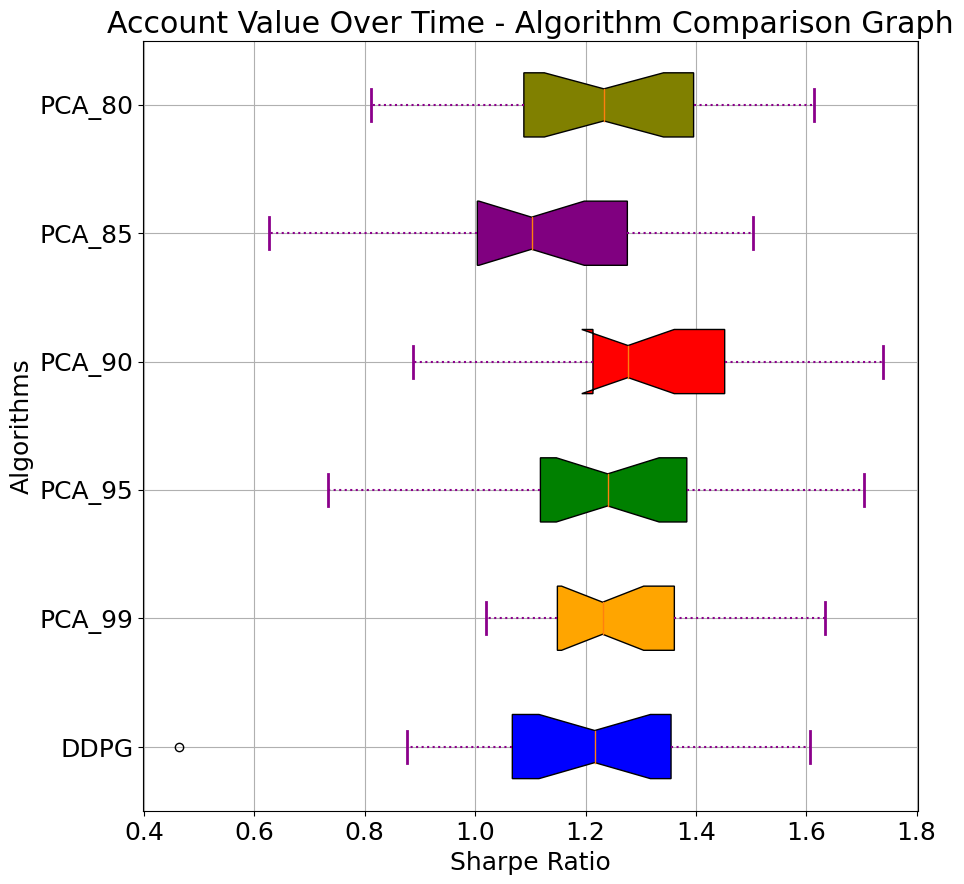

In [7]:
colors = ["blue", "orange", "green", "red", "purple", "olive"]
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.grid()
ax1.set_title(f'Account Value Over Time - Algorithm Comparison Graph')

bp = ax1.boxplot(
    [ddpg100.avg_agent.sharpe, ddpg99.avg_agent.sharpe, ddpg95.avg_agent.sharpe, ddpg90.avg_agent.sharpe, ddpg85.avg_agent.sharpe, ddpg80.avg_agent.sharpe],
    patch_artist = True,
    notch ='True', 
    vert = 0
)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B', linewidth = 1.5, linestyle =":")

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for cap in bp['caps']:
    cap.set(color ='#8B008B', linewidth = 2)

ax1.set_yticklabels(["DDPG", "PCA_99", "PCA_95", "PCA_90", "PCA_85", "PCA_80"])
ax1.set_ylabel("Algorithms")
ax1.set_xlabel("Sharpe Ratio")
plt.show()

### T-Test Results

In [25]:
p_value = stats.ttest_ind(ddpg100.avg_agent.sharpe, ddpg90.avg_agent.sharpe, equal_var = False).pvalue
print(f"P-Value: {round(p_value, 5)}, %: {round(p_value*100, 2)}")

P-Value: 0.08608, %: 8.61


### Will Coxon Results

In [23]:
p_value = stats.wilcoxon(ddpg100.avg_agent.sharpe, ddpg90.avg_agent.sharpe, alternative='less').pvalue
print(f"P-Value: {round(p_value, 5)}, %: {round(p_value*100, 2)}")

P-Value: 0.04865, %: 4.87


In [16]:
p_value = stats.ttest_ind([1.30], [1.52], equal_var = False).pvalue

p_value

nan

### Probabilistic Sharpe Ratio (PSR)

In [48]:
for i in range(len(ddpg90.avg_agent.sharpe)):
    prob = probabilistic_sharpe_ratio(
        sharpe_ratio = ddpg90.avg_agent.sharpe[i], 
        bench_sharpe_ratio = ddpg100.avg_agent.sharpe[i], 
        daily_returns = ddpg90.avg_agent.account_value[i].daily_return.dropna().tolist()
    )
    print(f"DDPG90 Sharpe: {round(ddpg90.avg_agent.sharpe[i], 1)}, DDPG100 Sharpe: {round(ddpg100.avg_agent.sharpe[i], 1)}, PRS: {round(prob, 5)}, %: {round(prob*100, 2)}")

DDPG90 Sharpe: 1.6, DDPG100 Sharpe: 1.2, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.4, DDPG100 Sharpe: 0.9, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.4, DDPG100 Sharpe: 1.3, PRS: 0.97342, %: 97.34
DDPG90 Sharpe: 1.2, DDPG100 Sharpe: 1.2, PRS: 0.618, %: 61.8
DDPG90 Sharpe: 1.3, DDPG100 Sharpe: 0.5, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.2, DDPG100 Sharpe: 1.6, PRS: 0.0, %: 0.0
DDPG90 Sharpe: 1.3, DDPG100 Sharpe: 0.9, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.7, DDPG100 Sharpe: 1.2, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.2, DDPG100 Sharpe: 1.5, PRS: 1e-05, %: 0.0
DDPG90 Sharpe: 1.2, DDPG100 Sharpe: 1.2, PRS: 0.50152, %: 50.15
DDPG90 Sharpe: 1.2, DDPG100 Sharpe: 1.1, PRS: 0.87541, %: 87.54
DDPG90 Sharpe: 1.1, DDPG100 Sharpe: 0.9, PRS: 0.99986, %: 99.99
DDPG90 Sharpe: 1.2, DDPG100 Sharpe: 1.3, PRS: 0.1034, %: 10.34
DDPG90 Sharpe: 1.4, DDPG100 Sharpe: 0.9, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.1, DDPG100 Sharpe: 1.4, PRS: 0.0, %: 0.0
DDPG90 Sharpe: 1.6, DDPG100 Sharpe: 1.1, PRS: 1.0, %: 100.0
DDPG90 Sharpe: 1.6, DDPG

In [49]:
daily_returns = pd.concat(ddpg90.avg_agent.account_value).daily_return.dropna().tolist()

prob = probabilistic_sharpe_ratio(
    sharpe_ratio = ddpg90.avg_agent.sharpe.mean(), 
    bench_sharpe_ratio = ddpg100.avg_agent.sharpe.mean(), 
    daily_returns = daily_returns
)

print(f"PRS: {round(prob, 5)}, %: {round(prob*100, 2)}")

PRS: 1.0, %: 100.0
